In [9]:
#!/usr/bin/env python
# coding: utf-8


#!/usr/bin/env python
# coding: utf-8


import numpy as np
import time as T
from joblib import Parallel, delayed
from scipy.interpolate import griddata,interpn,RegularGridInterpolator
import math
import os
import datetime
import cv2
from ftplib import FTP
import rioxarray
import xarray as xr
import paramiko
from scp import SCPClient
import subprocess
import datetime as dt
import numba as nb

target ='/data01/people/liwei/Data/Sichuan/'

SZA_PATH = '/data01/GEO/INPUT/ANGLE/Solar_Zenith_Angle_u2/'
SAA_PATH = '/data01/GEO/INPUT/ANGLE/Solar_Azimuth_Angle_u2/'
VZA_PATH = '/data01/GEO/INPUT/ANGLE/Viewer_Zenith_Angle/AHI_VZA_10.dat'
VAA_PATH = '/data01/GEO/INPUT/ANGLE/Viewer_Azimuth_Angle/AHI_VAA_10.dat'

LUT_PATH = '/data01/GEO/INPUT/LUT/'
CAMS_PATH = '/data01/GEO/INPUT/ATMOSPHERE/'
DN_PATH = '/data01/GEO/INPUT/'
CAMS_AERO_PATH = '/data01/GEO/INPUT/AEROSOL_TYPE/'
AL_PATH = '/data01/GEO/INPUT/ELEVATION_GEO/AHI/MERIT_DEM_AHI_10km.dat'


res = 0.01
u_lat,d_lat = 60,-60
l_lon,r_lon = 85,205

row_AHI = 12000
col_AHI = 12000

AHI_lat = np.linspace(35 - res/2 ,25 + res/2,1000)
AHI_lon = np.linspace(97 + res/2 ,109 - res/2,1200)


In [2]:

   
class H8_data:

    def __init__(self , account , pw , band , band_number , date):
        self.account = account
        self.pw = pw
        self.band = band
        self.band_number = band_number
        self.date = date
    
    def get_path(self):
        return '/data01/GEO/ORGDATA/H8AHI/hmwr829gr.cr.chiba-u.ac.jp/gridded/FD/V20151105/' + self.date[0:6] + '/' + self.band.upper() + '/'

    def get_filename(self):
        return self.date + "." + self.band + "." + self.band_number + ".fld.geoss.bz2"
    
    def DN2TBB(self,data):
        LUT=np.loadtxt(DN_PATH + 'count2tbb_v102/' + self.band + "." + self.band_number)
        return LUT[data,1]
    
    def file_path(self):
        return self.get_path() + self.get_filename() 
                 
    def download_H8data(self):
        client = paramiko.SSHClient()
        client.load_system_host_keys()
        client.set_missing_host_key_policy(paramiko.AutoAddPolicy())
        client.connect(hostname='10.4.123.47', port=22, username=self.account, password=self.pw)
        scp = SCPClient(client.get_transport())
        sftp = client.open_sftp()

        try :
            sftp.stat(self.file_path())

        except FileNotFoundError:
            client.close()
            print("File Not Found")
            return 'No data'

        else:
            scp.get(self.file_path(), folder_original+'/')
            p = subprocess.Popen('lbzip2 -d {}{}'.format(folder_original+'/',self.file_path()[-33:]),shell=True)
            p.communicate()
            client.close()
            print ('Himawari8/AHI data Processed Finish')
            return folder_original + self.get_filename()[:-4]
            
    def read_H8data(self):
        H8_file_path = self.download_H8data()
        if self.band == "vis":
            sr = 12000
        elif self.band == "ext":
            sr = 24000
        else:
            sr = 6000
        if H8_file_path != 'No data':
            fp = open(H8_file_path,'rb')
            data = np.frombuffer(fp.read(),dtype='>u2').reshape(sr,sr)
            fp.close()
            data = self.DN2TBB(data)
            data = data/100
            data = data.reshape(12000,2,12000,2).mean(-1).mean(1)
            print("data reading finish")
            return data[2500:3500,1200:2400]
        else:
            return 'No data'
        

In [3]:
class LUT_interpolation:
    def __init__(self,LUT_PATH):
        self.LUT_PATH = LUT_PATH
    
    def LUT_interpolation(self):
        
        X1 = np.loadtxt(self.LUT_PATH + "01_band3.csv",delimiter=",").reshape(2,8,5,12,5,17,17,19)
        X2 = np.loadtxt(self.LUT_PATH + "02_band3.csv",delimiter=",").reshape(2,8,5,12,5,17,17,19)
        X3 = np.loadtxt(self.LUT_PATH + "03_band3.csv",delimiter=",").reshape(2,8,5,12,5,17,17,19)
        # return X1, X2, X3
        
        fn1 = RegularGridInterpolator((aero_type,water,ozone,AOT,al,sza,vza,raa),X1,bounds_error=False,fill_value=np.nan)
        fn2 = RegularGridInterpolator((aero_type,water,ozone,AOT,al,sza,vza,raa),X2,bounds_error=False,fill_value=np.nan)
        fn3 = RegularGridInterpolator((aero_type,water,ozone,AOT,al,sza,vza,raa),X3,bounds_error=False,fill_value=np.nan)
        return fn1,fn2,fn3

class AHI_angle:
    def __init__(self,date):
        self.date = date        
    def read_angle_data(self):
        
        AHI_date = self.date[4:11]
        
        sza_file_name = 'AHI_SZA_2018{}5.dat'.format(AHI_date)
        saa_file_name = 'AHI_SAA_2018{}5.dat'.format(AHI_date)
        
        AHI_SZA_File = open(SZA_PATH + sza_file_name,'rb')
        AHI_SZA = np.frombuffer(AHI_SZA_File.read(),dtype='u2').reshape(3000,3000) / 100
        AHI_SZA_File.close()
        AHI_SZA=cv2.resize(np.array(AHI_SZA,dtype='float64'),(row_AHI,col_AHI),interpolation=cv2.INTER_NEAREST)
        
        
        AHI_SAA_File = open(SAA_PATH + saa_file_name,'rb')
        AHI_SAA = np.frombuffer(AHI_SAA_File.read(),dtype='u2').reshape(3000,3000) / 100
        AHI_SAA_File.close()
        AHI_SAA=cv2.resize(np.array(AHI_SAA,dtype='float64'),(row_AHI,col_AHI),interpolation=cv2.INTER_NEAREST)
        
        return AHI_SZA[1000:4000,3500:6500],AHI_SAA[1000:4000,3500:6500]

class AHI_angle:
    def __init__(self,date):
        self.date = date        
    def read_angle_data(self):
        
        AHI_date = self.date[4:11]
        
        sza_file_name = 'AHI_SZA_2018{}5.dat'.format(AHI_date)
        saa_file_name = 'AHI_SAA_2018{}5.dat'.format(AHI_date)
        
        AHI_SZA_File = open(SZA_PATH + sza_file_name,'rb')
        AHI_SZA = np.frombuffer(AHI_SZA_File.read(),dtype='u2').reshape(3000,3000) / 100
        AHI_SZA_File.close()
        AHI_SZA=cv2.resize(np.array(AHI_SZA,dtype='float64'),(row_AHI,col_AHI),interpolation=cv2.INTER_NEAREST)
        
        
        AHI_SAA_File = open(SAA_PATH + saa_file_name,'rb')
        AHI_SAA = np.frombuffer(AHI_SAA_File.read(),dtype='u2').reshape(3000,3000) / 100
        AHI_SAA_File.close()
        AHI_SAA=cv2.resize(np.array(AHI_SAA,dtype='float64'),(row_AHI,col_AHI),interpolation=cv2.INTER_NEAREST)
        
        return AHI_SZA[2500:3500,1200:2400],AHI_SAA[2500:3500,1200:2400]

class CAMS_data:
    def __init__(self,Y,M,D,H,MI,lat,lon):
        self.YYYY = Y
        self.MM = M
        self.DD = D
        self.HH = H
        self.MIN = MI
        self.lon = lon
        self.lat = lat
        
    def read_CAMS(self):

        if int(self.HH) >= 21:
            d1 = dt.datetime(int(self.YYYY),int(self.MM),int(self.DD))
            d2 = dt.datetime(int(self.YYYY),int(self.MM),int(self.DD)) + dt.timedelta(days=1)
            
            ds1 = xr.open_dataset(CAMS_PATH + d1.strftime('%Y') + d1.strftime('%m') + d1.strftime('%d') + '.nc')
            ds2 = xr.open_dataset(CAMS_PATH + d2.strftime('%Y') + d2.strftime('%m') + d2.strftime('%d') + '.nc')
            ds = xr.merge([ds1, ds2]) 
            
        else:
             ds = xr.open_dataset(CAMS_PATH + self.YYYY + self.MM + self.DD + '.nc')
                
        dtime = dt.datetime(int(self.YYYY),int(self.MM),int(self.DD),int(self.HH),int(self.MIN)+5)    
        ds = ds.interp(time = dtime,method = 'linear')
        ds = ds.interp(longitude=self.lon,latitude=self.lat,method="nearest")
        
        OZ = ds['gtco3'].values        
        WV = ds['tcwv'].values        
        AOT550 = ds['aod550'].values
#         Atmosphere data Unit conversion
        WV = WV/10
        OZ = OZ*46.6975764


#         Processing water vapor and ozone max and min
        OZ[OZ>=max(ozone)] = max(ozone)-(1/10000)
        OZ[OZ<=min(ozone)] = min(ozone)+(1/10000)
        WV[WV>=max(water)] = max(water)-(1/10000)
        WV[WV<=min(water)] = min(water)+(1/10000)
        AOT550[AOT550>=max(AOT)] = max(AOT)-(1/10000)
        AOT550[AOT550<=min(AOT)] = min(AOT)+(1/10000)
        
        return np.array(OZ).reshape(1000,1200),np.array(WV).reshape(1000,1200),np.array(AOT550).reshape(1000,1200)

    def read_CAMS_AERO(self):
        
                
        if int(self.HH) >= 21:
            d1 = dt.datetime(int(self.YYYY),int(self.MM),int(self.DD))
            d2 = dt.datetime(int(self.YYYY),int(self.MM),int(self.DD)) + dt.timedelta(days=1)
            
            ds1 = xr.open_dataset(CAMS_AERO_PATH + d1.strftime('%Y') + d1.strftime('%m') + d1.strftime('%d') + '.nc')
            ds2 = xr.open_dataset(CAMS_AERO_PATH + d2.strftime('%Y') + d2.strftime('%m') + d2.strftime('%d') + '.nc')
            ds = xr.merge([ds1, ds2]) 
            
        else:
             ds = xr.open_dataset(CAMS_AERO_PATH + self.YYYY + self.MM + self.DD + '.nc')
                
        dtime = dt.datetime(int(self.YYYY),int(self.MM),int(self.DD),int(self.HH),int(self.MIN)+5)
        ds = ds.interp(time = dtime,method = 'linear')
        ds = ds.interp(longitude=self.lon,latitude=self.lat,method="nearest")
        
        bc = ds['bcaod550'].values
        du = ds['duaod550'].values
        om = ds['omaod550'].values
        ss = ds['ssaod550'].values
        su = ds['suaod550'].values

        DL_6S = np.array(du)
        SL_6S = np.array(su) + np.array(bc)
        OC_6S = np.array(ss)
        WS_6S = np.array(om)

        Total = DL_6S + SL_6S + OC_6S + WS_6S

        precent_DL_6S = DL_6S / Total
        precent_SL_6S = SL_6S / Total
        precent_OC_6S = OC_6S / Total
        precent_WS_6S = WS_6S / Total
        P = np.dstack((precent_DL_6S,precent_WS_6S,precent_OC_6S,precent_SL_6S))
        Aerosol_type = np.where(np.amax(P,axis = 2) == precent_OC_6S,1,0)
        return Aerosol_type
    
def H8_Process(ACCOUNT,PW,Band,Band_number,Date):
    data = H8_data(ACCOUNT,PW,Band,Band_number,Date).read_H8data()
    return data

def remove_original_file(path):
    os.system('rm -rf {}'.format(path))
    
    
def mkdir(path):
    folder = os.path.exists(path) 
    if not folder:
        os.makedirs(path)
        
def Time_split(time):
    YYYY = time.strftime('%Y')
    MM = time.strftime('%m')
    DD = time.strftime('%d')
    HH = time.strftime('%H')
    MIN = time.strftime('%M')
    date = YYYY + MM + DD + HH + MIN
    return YYYY,MM,DD,HH,MIN,date
        
        
def calculate_6s_band3(i):
    
    Aero_input = Aerosol_type[i][Ocean_mask[i]]
    WV_input = WV[i][Ocean_mask[i]]
    OZ_input = OZ[i][Ocean_mask[i]]
    AOT550_input = AOT550[i][Ocean_mask[i]]
    RAA_input = RAA[i][Ocean_mask[i]]
    SZA_input = AHI_SZA[i][Ocean_mask[i]]
    VZA_input = AHI_VZA[i][Ocean_mask[i]]
    AL_input = AHI_AL[i][Ocean_mask[i]]
    AHI_data_input = AHI_data[i][Ocean_mask[i]]

    xi = np.array([Aero_input,WV_input,OZ_input,AOT550_input,AL_input,SZA_input,VZA_input,RAA_input])
    xi = xi.T
    xa = fn1(xi)
    xb = fn2(xi)
    xc = fn3(xi)
    y = xa*AHI_data_input-xb
    SR = y/(1+xc*y)
    return SR

@nb.jit()
def get_water_idx():
    Water_idx = []
    for i in range(1000):
        line_idx =[]
        for j in range(1200):
            if Ocean_mask[i,j] == True:
                line_idx.append(j)

        Water_idx.append(line_idx)
    return Water_idx

Ocean_mask_PATH = '/data01/GEO/INPUT/LAND_MASK/Landmask_10.dat'
    
Mask_File = open(Ocean_mask_PATH,'rb')
Ocean_mask = np.frombuffer(Mask_File.read(),dtype='u1').reshape(12000,12000)[2500:3500,1200:2400].astype('bool')
Mask_File.close()    
    
    
    
Water_idx = get_water_idx()
sza = np.linspace(0,80,17)
vza = np.linspace(0,80,17)
water = np.linspace(0,7,8)
ozone = np.linspace(0.2,0.4,5)
AOT = np.array([0.01,0.05,0.1,0.15,0.2,0.3,0.4,0.6,0.8,1.0,1.5,2.0])
raa = np.linspace(0,180,19)
al = np.linspace(0,8,5)
aero_type = np.array([0,1])

fn1,fn2,fn3 = LUT_interpolation(LUT_PATH).LUT_interpolation()


VZA_File = open(VZA_PATH,'rb')
AHI_VZA = np.frombuffer(VZA_File.read(),dtype='u2').reshape(12000,12000)[2500:3500,1200:2400] * 0.01
VZA_File.close()

VAA_File = open(VAA_PATH,'rb')
AHI_VAA = np.frombuffer(VAA_File.read(),dtype='u2').reshape(12000,12000)[2500:3500,1200:2400] * 0.01
VAA_File.close()

AL_File = open(AL_PATH,'rb')
AHI_AL = np.frombuffer(AL_File.read(),dtype='u2').reshape(12000,12000)[2500:3500,1200:2400] * 0.001
AL_File.close()
    

In [10]:

date_start = '2018-01-01 00:00'
date_end = '2018-01-31 09:00'
date_t = dt.timedelta(minutes=10)
date_s = dt.datetime.strptime(date_start, "%Y-%m-%d %H:%M")
date_e = dt.datetime.strptime(date_end, "%Y-%m-%d %H:%M")
date_time_now = date_s
while date_time_now <= date_e:
    start_time = T.time()
    date_dl_str = date_time_now.strftime("%Y-%m-%d %H:%M" )

    YYYY,MM,DD,HH,MIN,date= Time_split(date_time_now)    
    print("start processing {}".format(date))

    # make dir
    folder_original = target + date +'_original/'
    folder_AC = target+'{}/{}/{}/'.format(YYYY,MM,DD)
    mkdir(folder_original)
    mkdir(folder_AC)


    S_Read_AHI_time = T.time()
    # Download AHI
    AHI_data = H8_Process('liwei','liwei00','ext','01',date)
    if AHI_data == 'No data':
        date_time_now = date_time_now + date_t
        remove_original_file(folder_original)
        continue
    E_Read_AHI_time = T.time()

    # Solar angle
    print('Start reading Angle data')
    S_ANGLE_time = T.time()
    AHI_SZA,AHI_SAA = AHI_angle(date).read_angle_data()
    RAA = abs(AHI_SAA - AHI_VAA)
    RAA[RAA>180]=360-RAA[RAA>180]
    print('Angle data read finished')
    E_ANGLE_time = T.time()

    # Atmosphereic data
    print('Start reading Atmospheric data')
    S_ATMOS_time = T.time()

    OZ,WV,AOT550 = CAMS_data(YYYY,MM,DD,HH,MIN,AHI_lat,AHI_lon).read_CAMS()
    Aerosol_type = CAMS_data(YYYY,MM,DD,HH,MIN,AHI_lat,AHI_lon).read_CAMS_AERO()
    print('Atmospheric data read finished')
    E_ATMOS_time = T.time()


    # SR calculate
    print('Start Calculate SR')
    S_SR_time = T.time()
    RESULT = Parallel(n_jobs=40)(delayed(calculate_6s_band3)(i) for i in range(1000))
    SR = np.full((1000,1200),np.nan)
    for i in range(1000):
        SR[i][Water_idx[i]] = RESULT[i]
    E_SR_time = T.time()
    print('Calculate SR finished')
    
    # Save file and remove download input data
    print('Start Save SR file ')
    S_SAVE_time = T.time()
    SR=np.array(SR).reshape(1000,1200)
    SR = np.around(SR,4) * 10000
    SR = np.where(SR>=32767,32767,SR)
    SR = np.where(SR<=-32768,-32768,SR)
    SR_file=open(folder_AC+'H08_{}{}{}_{}{}_B03_SR.dat'.format(YYYY,MM,DD,HH,MIN),'wb')
    SR.astype('int16').tofile(SR_file)
    SR_file.close()
    print('Save SR file finished')
    remove_original_file(folder_original)
    print("delete file finish")
    E_SAVE_time = T.time()
    end_time=T.time()
    TIME=end_time-start_time
    print('time: {:.1f} secs, {:.1f} mins,{:.1f} hours'.format(TIME,TIME/60,TIME/3600))

    date_time_now = date_time_now + date_t

start processing 201801010000
Himawari8/AHI data Processed Finish
data reading finish
Start reading Angle data
Angle data read finished
Start reading Atmospheric data


<ipython-input-10-454f5667f051>:24: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if AHI_data == 'No data':


Atmospheric data read finished
Start Calculate SR
Calculate SR finished
Start Save SR file 
Save SR file finished
delete file finish
time: 22.3 secs, 0.4 mins,0.0 hours
start processing 201801010010
Himawari8/AHI data Processed Finish
data reading finish
Start reading Angle data
Angle data read finished
Start reading Atmospheric data


<ipython-input-10-454f5667f051>:24: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if AHI_data == 'No data':


Atmospheric data read finished
Start Calculate SR
Calculate SR finished
Start Save SR file 
Save SR file finished
delete file finish
time: 20.5 secs, 0.3 mins,0.0 hours
start processing 201801010020
Himawari8/AHI data Processed Finish
data reading finish
Start reading Angle data
Angle data read finished
Start reading Atmospheric data


<ipython-input-10-454f5667f051>:24: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if AHI_data == 'No data':


Atmospheric data read finished
Start Calculate SR
Calculate SR finished
Start Save SR file 
Save SR file finished
delete file finish
time: 20.6 secs, 0.3 mins,0.0 hours
start processing 201801010030
Himawari8/AHI data Processed Finish
data reading finish
Start reading Angle data
Angle data read finished
Start reading Atmospheric data


<ipython-input-10-454f5667f051>:24: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if AHI_data == 'No data':


Atmospheric data read finished
Start Calculate SR
Calculate SR finished
Start Save SR file 
Save SR file finished
delete file finish
time: 21.8 secs, 0.4 mins,0.0 hours
start processing 201801010040
Himawari8/AHI data Processed Finish
data reading finish
Start reading Angle data
Angle data read finished
Start reading Atmospheric data


<ipython-input-10-454f5667f051>:24: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if AHI_data == 'No data':


Atmospheric data read finished
Start Calculate SR
Calculate SR finished
Start Save SR file 
Save SR file finished
delete file finish
time: 22.9 secs, 0.4 mins,0.0 hours
start processing 201801010050
Himawari8/AHI data Processed Finish
data reading finish
Start reading Angle data
Angle data read finished
Start reading Atmospheric data


<ipython-input-10-454f5667f051>:24: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if AHI_data == 'No data':


Atmospheric data read finished
Start Calculate SR
Calculate SR finished
Start Save SR file 
Save SR file finished
delete file finish
time: 23.1 secs, 0.4 mins,0.0 hours
start processing 201801010100


FileNotFoundError: [Errno 2] No such file or directory

In [313]:
TOA_Ref = []
SR_Ref = []

for d in range(12,22):
    date_start = '2018-01-{} 04:50'.format(d)
    date_end = '2018-01-{} 04:50'.format(d)
    # date_t = dt.timedelta(minutes=10)
    date_s = dt.datetime.strptime(date_start, "%Y-%m-%d %H:%M")
    date_e = dt.datetime.strptime(date_end, "%Y-%m-%d %H:%M")
    date_time_now = date_s
    while date_time_now <= date_e:
        start_time = T.time()
        date_dl_str = date_time_now.strftime("%Y-%m-%d %H:%M" )

        YYYY,MM,DD,HH,MIN,date= Time_split(date_time_now)    
        print("start processing {}".format(date))

        # make dir
        folder_original = target + date +'_original/'
        folder_AC = target+'{}/{}/{}/'.format(YYYY,MM,DD)
        mkdir(folder_original)
        mkdir(folder_AC)


        S_Read_AHI_time = T.time()
        # Download AHI
        AHI_data = H8_Process('liwei','liwei00','ext','01',date)
        if AHI_data == 'No data':
            date_time_now = date_time_now + date_t
            remove_original_file(folder_original)
            continue
        TOA_Ref.append(AHI_data[1389,1740])
        E_Read_AHI_time = T.time()

        # Solar angle
        print('Start reading Angle data')
        S_ANGLE_time = T.time()
        AHI_SZA,AHI_SAA = AHI_angle(date).read_angle_data()
        RAA = abs(AHI_SAA - AHI_VAA)
        RAA[RAA>180]=360-RAA[RAA>180]
        print('Angle data read finished')
        E_ANGLE_time = T.time()

        # Atmosphereic data
        print('Start reading Atmospheric data')
        S_ATMOS_time = T.time()

        OZ,WV,AOT550 = CAMS_data(YYYY,MM,DD,HH,MIN,AHI_lat,AHI_lon).read_CAMS()
        Aerosol_type = CAMS_data(YYYY,MM,DD,HH,MIN,AHI_lat,AHI_lon).read_CAMS_AERO()
        print('Atmospheric data read finished')
        E_ATMOS_time = T.time()


        # SR calculate
        print('Start Calculate SR')
        S_SR_time = T.time()
        RESULT = Parallel(n_jobs=40)(delayed(calculate_6s_band3)(i) for i in range(3000))
        SR = np.full((3000,3000),np.nan)
        for i in range(3000):
            SR[i][Water_idx[i]] = RESULT[i]
        E_SR_time = T.time()
        print('Calculate SR finished')

        # Save file and remove download input data
        print('Start Save SR file ')
        S_SAVE_time = T.time()
        SR=np.array(SR).reshape(3000,3000)
        SR = np.around(SR,4) * 10000
        SR = np.where(SR>=32767,32767,SR)
        SR = np.where(SR<=-32768,-32768,SR)
        SR_Ref.append(SR[1389,1740])
        SR_file=open(folder_AC+'H08_{}{}{}_{}{}_B03_SR.dat'.format(YYYY,MM,DD,HH,MIN),'wb')
        SR.astype('int16').tofile(SR_file)
        SR_file.close()
        print('Save SR file finished')
        remove_original_file(folder_original)
        print("delete file finish")
        E_SAVE_time = T.time()
        end_time=T.time()
        TIME=end_time-start_time
        print('time: {:.1f} secs, {:.1f} mins,{:.1f} hours'.format(TIME,TIME/60,TIME/3600))


        date_time_now = date_time_now + date_t

start processing 201801120450
Himawari8/AHI data Processed Finish
data reading finish
Start reading Angle data


<ipython-input-313-e21714305616>:28: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if AHI_data == 'No data':


Angle data read finished
Start reading Atmospheric data
Atmospheric data read finished
Start Calculate SR
Calculate SR finished
Start Save SR file 
Save SR file finished
delete file finish
time: 36.0 secs, 0.6 mins,0.0 hours
start processing 201801130450
Himawari8/AHI data Processed Finish
data reading finish
Start reading Angle data


<ipython-input-313-e21714305616>:28: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if AHI_data == 'No data':


Angle data read finished
Start reading Atmospheric data
Atmospheric data read finished
Start Calculate SR
Calculate SR finished
Start Save SR file 
Save SR file finished
delete file finish
time: 30.0 secs, 0.5 mins,0.0 hours
start processing 201801140450
Himawari8/AHI data Processed Finish
data reading finish
Start reading Angle data


<ipython-input-313-e21714305616>:28: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if AHI_data == 'No data':


Angle data read finished
Start reading Atmospheric data
Atmospheric data read finished
Start Calculate SR
Calculate SR finished
Start Save SR file 
Save SR file finished
delete file finish
time: 34.1 secs, 0.6 mins,0.0 hours
start processing 201801150450
Himawari8/AHI data Processed Finish
data reading finish
Start reading Angle data


<ipython-input-313-e21714305616>:28: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if AHI_data == 'No data':


Angle data read finished
Start reading Atmospheric data
Atmospheric data read finished
Start Calculate SR
Calculate SR finished
Start Save SR file 
Save SR file finished
delete file finish
time: 33.7 secs, 0.6 mins,0.0 hours
start processing 201801160450
Himawari8/AHI data Processed Finish
data reading finish
Start reading Angle data


<ipython-input-313-e21714305616>:28: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if AHI_data == 'No data':


Angle data read finished
Start reading Atmospheric data
Atmospheric data read finished
Start Calculate SR
Calculate SR finished
Start Save SR file 
Save SR file finished
delete file finish
time: 32.5 secs, 0.5 mins,0.0 hours
start processing 201801170450
Himawari8/AHI data Processed Finish
data reading finish
Start reading Angle data


<ipython-input-313-e21714305616>:28: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if AHI_data == 'No data':


Angle data read finished
Start reading Atmospheric data
Atmospheric data read finished
Start Calculate SR
Calculate SR finished
Start Save SR file 
Save SR file finished
delete file finish
time: 30.2 secs, 0.5 mins,0.0 hours
start processing 201801180450
Himawari8/AHI data Processed Finish
data reading finish
Start reading Angle data


<ipython-input-313-e21714305616>:28: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if AHI_data == 'No data':


Angle data read finished
Start reading Atmospheric data
Atmospheric data read finished
Start Calculate SR
Calculate SR finished
Start Save SR file 
Save SR file finished
delete file finish
time: 30.4 secs, 0.5 mins,0.0 hours
start processing 201801190450
Himawari8/AHI data Processed Finish
data reading finish
Start reading Angle data


<ipython-input-313-e21714305616>:28: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if AHI_data == 'No data':


Angle data read finished
Start reading Atmospheric data
Atmospheric data read finished
Start Calculate SR
Calculate SR finished
Start Save SR file 
Save SR file finished
delete file finish
time: 31.9 secs, 0.5 mins,0.0 hours
start processing 201801200450
Himawari8/AHI data Processed Finish
data reading finish
Start reading Angle data


<ipython-input-313-e21714305616>:28: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if AHI_data == 'No data':


Angle data read finished
Start reading Atmospheric data
Atmospheric data read finished
Start Calculate SR
Calculate SR finished
Start Save SR file 
Save SR file finished
delete file finish
time: 33.9 secs, 0.6 mins,0.0 hours
start processing 201801210450
Himawari8/AHI data Processed Finish
data reading finish
Start reading Angle data


<ipython-input-313-e21714305616>:28: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if AHI_data == 'No data':


Angle data read finished
Start reading Atmospheric data
Atmospheric data read finished
Start Calculate SR
Calculate SR finished
Start Save SR file 
Save SR file finished
delete file finish
time: 33.5 secs, 0.6 mins,0.0 hours


In [315]:
np.array(TOA_Ref).reshape(10)

array([0.10529411, 0.20867647, 0.08367647, 0.0892647 , 0.12      ,
       0.36147058, 0.20970588, 0.06647058, 0.07441177, 0.11485294])

In [317]:
np.array(SR_Ref)/10000

array([0.0703, 0.205 , 0.0486, 0.0466, 0.0828, 0.3951, 0.2028, 0.0141,
       0.0253, 0.0641])

In [279]:
AHI_SZA[1389,1740]

13.7

In [280]:
RAA[1389,1740]

13.480000000000018

In [281]:
AOT550[1389,1740]

0.1278553671307034

In [282]:
OZ[1389,1740]

0.2959947651325768

In [283]:
WV[1389,1740]

3.4065362506442596

In [266]:
AHI_AL[1389,1740]

1.069

In [267]:
AHI_VZA[1389,1740]

42.04

In [268]:
Aerosol_type[1389,1740]

0

In [285]:
S = []
for i in np.arange(0.01,1,0.01):
    y = xa*i-xb
    S.append(y/(1+xc*y))

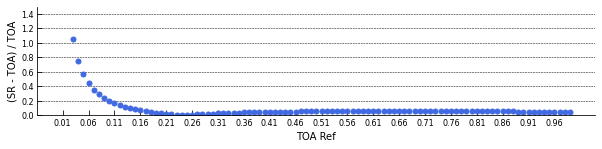

In [286]:
import matplotlib.pyplot as plt

fig,ax1 = plt.subplots(figsize=(10,2))

# ax1.plot(0,-1,color = 'royalblue',marker="o",markersize=10,linewidth=0,label = 'AHI SZA')
ax1.plot(np.arange(0.01,1,0.01),abs((np.array(S).reshape(-1) - np.arange(0.01,1,0.01))/np.arange(0.01,1,0.01)),color = 'royalblue',marker="o",markersize=5,linewidth=0)

ax1.spines['right'].set_color('none')
ax1.spines['top'].set_color('none')

ax1.tick_params(axis="y",which='major',length=5,direction='in',labelsize=8)
ax1.tick_params(axis="x",which='major',length=5,direction='in',labelsize=8)

ax1.set_xticks(np.arange(0.01,1,0.05))
ax1.set_yticks(np.arange(0, 1.5,0.2))
ax1.set_ylim((0, 1.5))

ax1.set_ylabel("(SR - TOA) / TOA")
ax1.set_xlabel("TOA Ref")

ax1.grid(axis = 'y',color = 'k', linestyle = '--', linewidth = 0.5)

# plt.title('2018/01',fontsize=12 )
plt.show()
# fig.savefig('{} angle.jpg'.format(site_name),dpi = 1000,bbox_inches = 'tight')

In [284]:
xi = np.array([Aerosol_type[1389,1740],WV[1389,1740],OZ[1389,1740],AOT550[1389,1740],AHI_AL[1389,1740],AHI_SZA[1389,1740],AHI_VZA[1389,1740],RAA[1389,1740]])
xi = xi.T
xa = fn1(xi)
xb = fn2(xi)
xc = fn3(xi)
y = xa*0.06647058-xb
y/(1+xc*y)

array([0.04099551])

In [201]:
from Py6S import *
wl_band = "/data01/people/liwei/AHI_AC/AHI_SRF/sixs_band3.csv"
band = np.loadtxt(wl_band,delimiter=",")
s = SixS('/data01/people/liwei/source/6SV-1.1/6SV1.1/sixs')
s.atmos_profile = AtmosProfile.UserWaterAndOzone(WV[1389,1740],OZ[1389,1740])
s.aero_profile = AeroProfile.PredefinedType(1)
s.aot550 = AOT550[1389,1740]
s.wavelength = Wavelength(band[0,0],band[band.shape[0]-1,0],band[:,1])
s.altitudes.set_sensor_satellite_level()
s.altitudes.set_target_custom_altitude(AHI_AL[1389,1740])
s.geometry = Geometry.User()
s.geometry.solar_z = AHI_SZA[1389,1740]
s.geometry.solar_a = RAA[1389,1740]
s.geometry.view_z = AHI_VZA[1389,1740]
s.geometry.view_a = 0

s.atmos_corr = AtmosCorr.AtmosCorrLambertianFromReflectance(0.2)
s.run() 
f1 = 1/(s.outputs.transmittance_total_scattering.total*s.outputs.transmittance_global_gas.total)
y = f1*0.06647058-s.outputs.coef_xb
y/(1+s.outputs.coef_xc*y)


0.01497410376296854

In [304]:
np.array(SR_Ref).shape

(7, 3000, 3000)

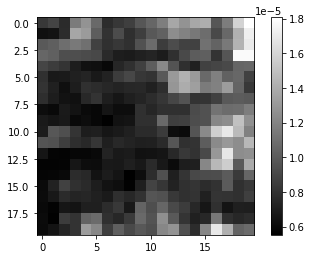

In [306]:
plt.imshow(np.array(TOA_Ref[0])[1379:1399,1730:1750]/10000,cmap='gray')
plt.colorbar()

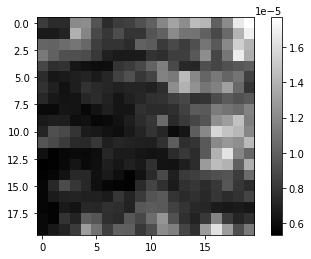

In [307]:
plt.imshow(np.array(TOA_Ref[1])[1379:1399,1730:1750]/10000,cmap='gray')
plt.colorbar()

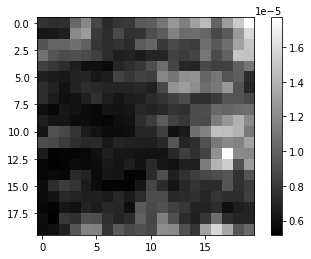

In [308]:
plt.imshow(np.array(TOA_Ref[2])[1379:1399,1730:1750]/10000,cmap='gray')
plt.colorbar()

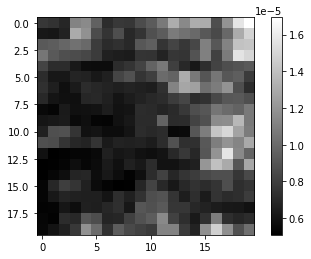

In [309]:
plt.imshow(np.array(TOA_Ref[3])[1379:1399,1730:1750]/10000,cmap='gray')
plt.colorbar()

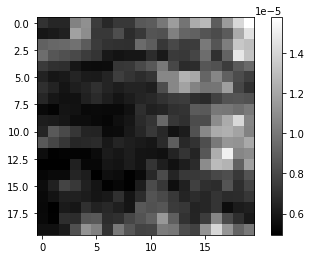

In [310]:
plt.imshow(np.array(TOA_Ref[4])[1379:1399,1730:1750]/10000,cmap='gray')
plt.colorbar()

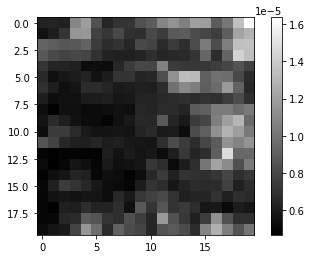

In [311]:
plt.imshow(np.array(TOA_Ref[5])[1379:1399,1730:1750]/10000,cmap='gray')
plt.colorbar()